# Derivations for all terms needed to implement kSpace Jastrows

In [1]:
from sympy import *
from sympy.vector import *
init_printing()

In [2]:
x = symbols('x')
J = Function('J')
wfc = exp(J(x))
wfc

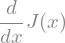

In [3]:
G = diff(wfc, x) / wfc
G

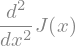

In [4]:
L = diff(wfc,x,2)/wfc - G*G
L

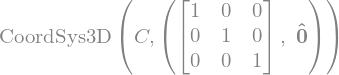

In [5]:
C = CoordSys3D('C')
C

In [6]:
x = IndexedBase('x', real=True)
y = IndexedBase('y', real=True)
z = IndexedBase('z', real=True)
gx = IndexedBase('g^x', real=True)
gy = IndexedBase('g^y', real=True)
gz = IndexedBase('g^z', real=True)
a = IndexedBase('a', real=True)
br = IndexedBase('b^r', real=True)
bi = IndexedBase('b^i', real=True)
i, j, k, l, mu, V, nu = symbols('i j k l mu V nu')
r = lambda i: x[i] * C.i + y[i] * C.j + z[i] * C.k
g = lambda i: gx[i] * C.i + gy[i] * C.j + gz[i] * C.k
Ne, Ng = symbols('N_e N_G', positive=True)

In [7]:
rhoG = lambda mu, i: Sum(exp(I * dot(g(mu), r(i))), (i,0,Ne))
rhomG = lambda mu, i: conjugate(rhoG(mu,i))
Jk1 = lambda mu, i: re(Sum((br[mu] + I * bi[mu]) * rhomG(mu,i), (mu,1,Ng)))
Jk2 = lambda mu, i,j : Sum(a[mu] * rhoG(mu,i) * rhomG(mu,j), (mu,1,Ng))

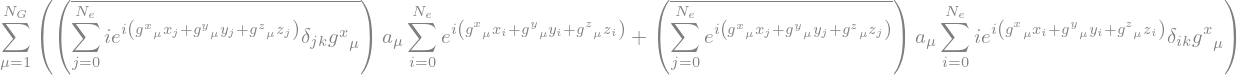

In [8]:
pgradx = diff(Jk2(mu,i,j), x[k]); pgradx

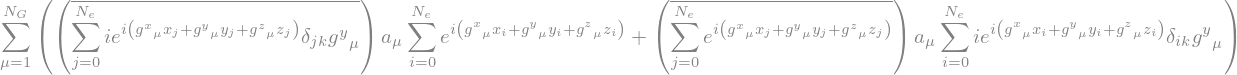

In [9]:
pgrady = diff(Jk2(mu,i,j), y[k]); pgrady

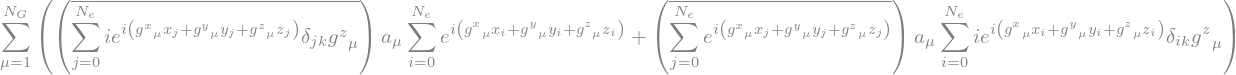

In [10]:
pgradz = diff(Jk2(mu,i,j), z[k]); pgradz

In [11]:
pgrad = [ pgradx, pgrady, pgradz ]
plap = diff(pgradx, x[k]) + diff(pgrady, y[k]) + diff(pgradz, z[k])

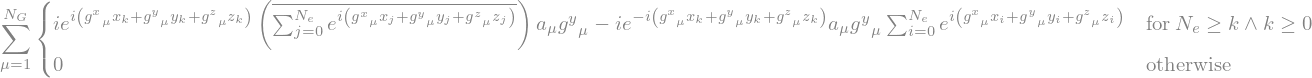

In [12]:
pgrad[1].doit()

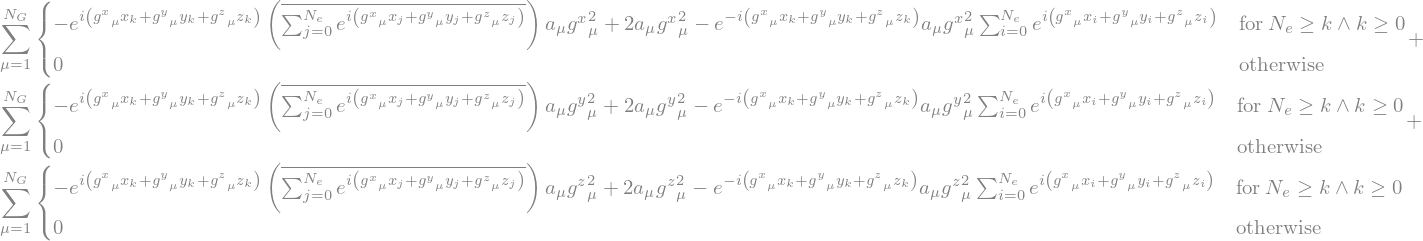

In [13]:
plap.doit()

In [14]:
dparam_grad = [ diff(grad, a[nu]) for grad in pgrad ]

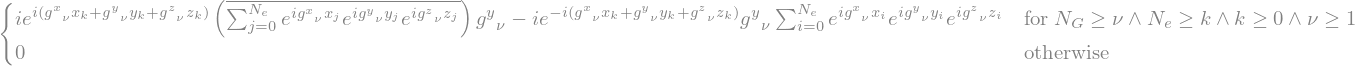

In [15]:
dparam_grad[1].doit()

In [16]:
dparam_lap = diff(plap, a[nu])

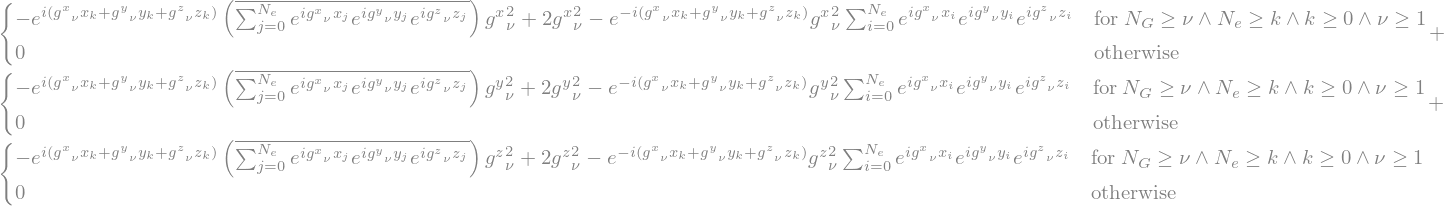

In [17]:
dparam_lap.doit()

## Jk1 now

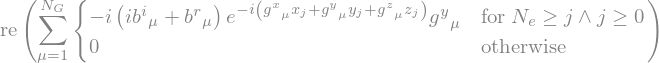

In [18]:
pgrad = [ diff(Jk1(mu,i), x[j]), diff(Jk1(mu,i), y[j]), diff(Jk1(mu,i), z[j]) ]
pgrad[1].doit()

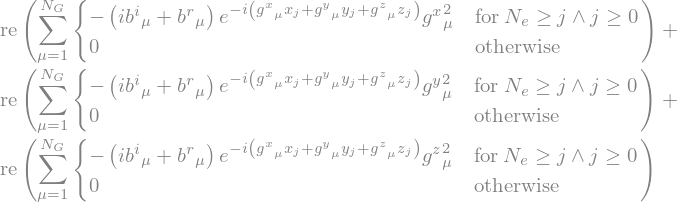

In [19]:
plap = diff(pgrad[0], x[j]) + diff(pgrad[1], y[j]) + diff(pgrad[2], z[j])
plap.doit()

In [20]:
dparamr_grad = [ diff(grad, br[nu]) for grad in pgrad ] 
dparami_grad = [ diff(grad, bi[nu]) for grad in pgrad ]

dparamr_lap = diff(plap, br[nu])
dparami_lap = diff(plap, bi[nu])

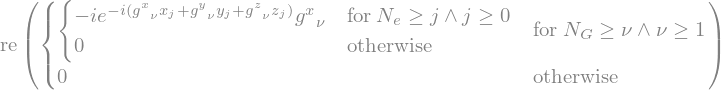

In [21]:
dparamr_grad[0].doit()

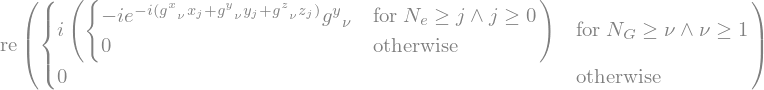

In [22]:
dparami_grad[1].doit()

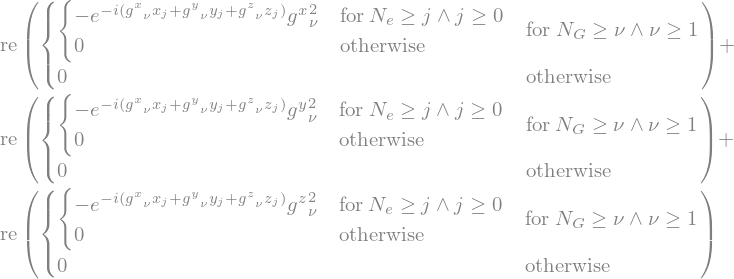

In [23]:
dparamr_lap.doit()

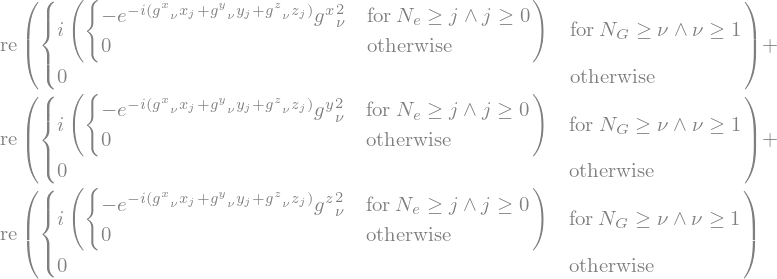

In [24]:
dparami_lap.doit()

# Toy system for unit testing

In [25]:
import numpy as np

In [26]:
def makeTriclinic(a, b, c, alpha, beta, gamma):
    A = np.array([a,0,0])
    B = np.array([b * np.cos(gamma), b * np.sin(gamma), 0])
    cx = c * np.cos(beta)
    cy = c * (np.cos(alpha) - np.cos(beta) * np.cos(gamma)) / np.sin(gamma)
    cz = np.sqrt(c**2 - cx**2 - cy**2)
    C = np.array([cx, cy, cz])

    return np.array([A,B,C])

def getVolume(L):
    V = np.dot(L[0], np.cross(L[1],L[2]))
    return V

def getReciprocal(L):
    Gt = (2 * np.pi) * np.linalg.inv(L)
    return Gt.T

def kf_rpa(nelec, L):
    V = getVolume(L)
    kvol = (2*np.pi)**3/V
    kf = ((3 * nelec * kvol) / (4 * np.pi))**(1./3.)
    return kf

In [27]:
def registerGvecs(gmax, G):
    def checkInclude(i,j,k):
        if i > 0:
            return True
        elif i == 0:
            if j > 0:
                return True
            elif j == 0 and k > 0:
                return True
        else:
            return False
    gvecs = []
    for m1 in range(-5, 6):
        for m2 in range(-5, 6):
            for m3 in range(-5, 6):
                include = checkInclude(m1, m2, m3)
                gvec = m1 * G[0] + m2 * G[1] + m3 * G[2]
                dot = np.dot(gvec, gvec)
                if dot < gmax**2 and dot > 0 and include:
                    gvecs.append(gvec)

    idx = np.argsort([ np.dot(gvecs[i], gvecs[i]) for i in range(len(gvecs)) ])
    return np.array(gvecs)[idx]


In [28]:
def rhoGmG(r, gvec):
    pG = 0
    mG = 0
    for ie in range(len(r)):
        dot = np.dot(gvec, r[ie])
        pG += np.cos(dot) + 1j*np.sin(dot)
        mG += np.cos(dot) - 1j*np.sin(dot)
    return pG, mG

def logJk1(r, R, gvecs, coeffs, V):
    # in qmcpack, we factor out the constant term rhoIG. I calculate it here following the definition in the manual
    # but then just set it to 1. We also take only the real part in the code
    val = 0
    for ig in range(len(gvecs)):
        rhoG, rhomG = rhoGmG(r, gvecs[ig])
        rhoIG, rhomIG = rhoGmG(R, gvecs[ig])
        rhoIG = 1
        val += coeffs[ig] * rhoIG * rhomG
    return (val / V).real

def logJk2(r, gvecs, coeffs, V):
    val = 0
    for ig in range(len(gvecs)):
        rhoG, rhomG = rhoGmG(r, gvecs[ig])
        val += coeffs[ig] * rhoG * rhomG
    return (val / V).real

def dlogJk1(r, R, gvecs, coeffs, V):
    # in qmcpack, we factor out the constant term rhoIG. I calculate it here following the definition in the manual
    # but then just set it to 1. 
    derivs = np.zeros(len(coeffs), dtype=complex)
    for ig in range(len(gvecs)):
        rhoG, rhomG = rhoGmG(r, gvecs[ig])
        rhoIG, rhoImG = rhoGmG(R, gvecs[ig])
        rhoIG = 1
        val = rhoIG * rhomG / V

        #df(z)/da = df/dz dz/da and df(z)/db = df/dz dz/db for z = a + ib
        #so df(z)/da = df/dz and df(z)/db = i df/dz where f(z) is real even though z is complex
        derivs[ig] = np.real(val.real) + 1.j * np.real(1.j * val) 
    return derivs

def dlogJk2(r, gvecs, coeffs, V):
    derivs = np.zeros(len(coeffs))
    for ig in range(len(gvecs)):
        rhoG, rhomG = rhoGmG(r, gvecs[ig])
        deriv = rhoG * rhomG / V
        assert np.abs(deriv.imag) < 1e-12
        derivs[ig] = deriv.real
    return derivs  

def kineticJk1(r, R, gvecs, coeffs, V, show = False):
    #ignore the rhoIG contribution, set as 1
    pgrad = np.zeros((len(r), 3), dtype=complex)
    plap = np.zeros(len(r), dtype = complex)

    for ig in range(len(gvecs)):
        for ie in range(len(r)):
            z = np.dot(gvecs[ig], r[ie])
            epz = np.cos(z) + 1j * np.sin(z)
            emz = np.cos(z) - 1j * np.sin(z)
            
            pgrad[ie][:] += (-1j * coeffs[ig] * gvecs[ig][:] * emz / V).real
            plap[ie] += ((-coeffs[ig] * gvecs[ig]**2 * emz ).sum() / V).real


    if show:
        print("pgrad:\n{}".format(pgrad))
        print("plap:\n{}".format(plap))

    kin = 0
    for ie in range(len(r)):
        kin += -0.5 * (plap[ie] + np.dot(pgrad[ie], pgrad[ie]))
        
    return kin


def kineticJk2(r, gvecs, coeffs, V, show = False):
    pgrad = np.zeros((len(r), 3), dtype=complex)
    plap = np.zeros(len(r), dtype = complex)
    
    for ig in range(len(gvecs)):
        rhoG, rhomG = rhoGmG(r, gvecs[ig])

        for ie in range(len(r)):
            z = np.dot(gvecs[ig], r[ie])
            epz = np.cos(z) + 1j * np.sin(z)
            emz = np.cos(z) - 1j * np.sin(z)
            pgrad[ie][:] += 1j * coeffs[ig] * gvecs[ig][:] * (epz * rhomG - emz * rhoG) / V
            plap[ie] += (coeffs[ig] * gvecs[ig]**2 * (2 - epz * rhomG - emz * rhoG)).sum() / V
    if show:
        print("pgrad:\n{}".format(pgrad))
        print("plap:\n{}".format(plap))

    kin = 0
    for ie in range(len(r)):
        kin += -0.5 * (plap[ie] + np.dot(pgrad[ie], pgrad[ie]))
    return kin

def dparam_kineticJk1(r, R, gvecs, coeffs, V):
    dp = 1e-6
    for ip in range(2 * len(coeffs)):
        newcoeffs = coeffs.copy()
        if ip%2 == 0:
            newcoeffs[int(ip/2)] += dp
        else:
            newcoeffs[int(ip/2)] += 1j*dp
        kp = kineticJk1(r, R, gvecs, newcoeffs, V)

        newcoeffs = coeffs.copy()
        if ip%2 == 0:
            newcoeffs[int(ip/2)] -= dp
        else:
            newcoeffs[int(ip/2)] -= 1j*dp
        km = kineticJk1(r, R, gvecs, newcoeffs, V)

 
        print(ip, (kp - km)/(2*dp))
            
def dparam_kineticJk2(r, gvecs, coeffs, V):
    dp = 1e-6
    for ip in range(len(coeffs)):
        newcoeffs = coeffs.copy()
        newcoeffs[ip] += dp
        kp = kineticJk2(r, gvecs, newcoeffs, V)

        newcoeffs = coeffs.copy()
        newcoeffs[ip] -= dp
        km = kineticJk2(r, gvecs, newcoeffs, V)
        print(ip, (kp - km)/(2 * dp))

In [29]:
def runChecks(): 
    np.random.seed(123454321)
    L = makeTriclinic(1,2,3, np.radians(65), np.radians(84), np.radians(98))
    G = getReciprocal(L)
    kf = kf_rpa(2, L)
    kf = 5
    gvecs = registerGvecs(kf, G)
    
    print("Lattice :\n{}" .format(L))
    print("kmax    : {}".format(kf))
    print("ng      : {}".format(len(gvecs)))
    print("gvecs   :\n{}".format(gvecs))

    #elec
    r = np.array([[0.1,0.2,0.3], [0.4,0.5,0.6]])
    #ion
    R = np.array([[0.7, 0.8, 0.9]])

    #randomize coefficients
    jk1c = []
    jk2c = []
    for i in range(len(gvecs)):
        jk1c.append( np.random.random() + 1j*np.random.random() )
        jk2c.append( np.random.random())

    print("Jk1 coeffs: {}".format(jk1c))
    print("Jk2 coeffs: {}".format(jk2c))

    V = getVolume(L)
    val1 = logJk1(r, R, gvecs, jk1c, V)
    val2 = logJk2(r, gvecs, jk2c, V)
    d1 = dlogJk1(r, R, gvecs, jk1c, V)
    d2 = dlogJk2(r, gvecs, jk2c, V)

    print()
    print("Jk1  : {}".format(val1))
    print("JK2  : {}".format(val2))
    print("dratio Jk1: {}".format( d1))
    print("dratio Jk2: {}".format( d2))

    print("\n\n")
    print("Kinetic Jk1")
    kineticJk1(r, R, gvecs, jk1c, V, True)
    dparam_kineticJk1(r, R, gvecs, jk1c, V)

    print("\n\n")
    print("Kinetic Jk2")
    kineticJk2(r, gvecs, jk2c, V, True)

    dparam_kineticJk2(r, gvecs, jk2c, V)
    
runChecks()

Lattice :
[[ 1.          0.          0.        ]
 [-0.2783462   1.98053614  0.        ]
 [ 0.31358539  1.32438627  2.67351177]]
kmax    : 5
ng      : 5
gvecs   :
[[ 0.          0.          2.35016182]
 [ 0.          3.17246688  0.77860653]
 [ 0.          3.17246688 -1.5715553 ]
 [ 0.          3.17246688  3.12876835]
 [ 0.          0.          4.70032365]]
Jk1 coeffs: [(0.8137632591137914+0.44470998182408406j), (0.5401857355121155+0.25752329923480577j), (0.8232477489081528+0.44767385249164526j), (0.6464929258779923+0.4929171993220475j), (0.7846576485476944+0.662660459182017j)]
Jk2 coeffs: [0.9531019536367156, 0.18148850587408794, 0.20772539137877666, 0.9340655612889098, 0.50544913283957]

Jk1  : 0.7137163755813973
JK2  : 1.3399793692340471
dratio Jk1: [ 0.17404927+0.30881786j  0.03441212+0.31140348j  0.3374628 +0.14393708j
 -0.17959687+0.12910817j -0.14896848+0.2460836j ]
dratio Jk2: [0.66537659 0.51973641 0.71270004 0.25905169 0.4381535 ]



Kinetic Jk1
pgrad:
[[ 0.        +0.j -0.3506